## Use ResNet to train a classifier on CIFAR10 dataset

In [1]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks/SC201_L16'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SC201_L16


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
import torchvision.datasets as dset
from torchvision import models

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
device

device(type='cuda')

In [4]:
# 如果發生SSLCertVerificationError，可執行下列指令
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load Existing Dataset
transform = T.Compose(
    [T.Resize((224,224)), T.ToTensor(),
     # ImageNet
     T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

train_data = dset.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)

val_data = dset.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Check Data Dimension
print(train_data)
print(val_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CIFAR10
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [7]:
# Create Mini-batches
mini_trains = DataLoader(train_data, batch_size=10, shuffle=True)
mini_vals = DataLoader(val_data, batch_size=10, shuffle=True)

In [8]:
# 10 Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
      'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([8, 3, 224, 224])


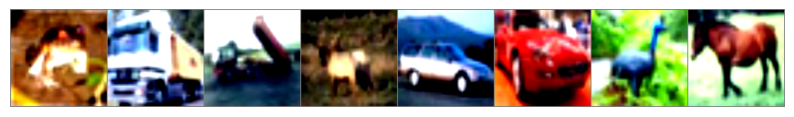

frog  truck truck deer  car   car   bird  horse


In [9]:
# Function of showing images
def imshow(img):
    img = img * 0.5 + 0.5  # 還原圖像
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 顏色換至最後一維(32x32x3 -> 3x32x32)
    plt.axis('off')
    plt.show()

# Get one batch of data
batch_size_tmp = 8
train_loader_tmp = DataLoader(train_data, batch_size=batch_size_tmp)
dataiter = iter(train_loader_tmp)
images, labels = next(dataiter)
print(images.shape)

# Show images
plt.figure(figsize=(10,6))
imshow(torchvision.utils.make_grid(images))

# Show classes
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size_tmp))) 

In [10]:
# Build Model
# Transfer Learning
resnet = models.resnet18(pretrained=True)
num_flatten = resnet.fc.in_features
resnet.fc = nn.Linear(num_flatten, 10)
model = resnet

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


In [11]:
# Move model to GPU
model = model.to(device)

In [12]:
PRINT_EVERY = 1000
train_loss = []

In [13]:
# Training Procedure
def train(model, device, mini_trains, mini_vals, criterion, optimizer, epochs):
  for epoch in range(epochs):   
    for batch_idx, (data, target) in enumerate(mini_trains):
      model.train()
      data, target = data.to(device), target.to(device)

      output = model(data)  
      optimizer.zero_grad()
      loss = criterion(output, target)
      train_loss.append(loss.item())
      loss.backward()
      optimizer.step()
        
      if (batch_idx+1) % PRINT_EVERY == 0:
        batch = (batch_idx+1) * len(data)
        data_count = len(mini_trains.dataset)
        print('Epoch %d: [%d / %d], Loss: %.4f' % (epoch, batch, data_count, loss.item()))
        evaluate(model, device, mini_vals)
        print()

In [14]:
# Validating Procedure
def evaluate(model, device, mini_vals):
  model.eval()
  correct = 0
  with torch.no_grad():
    for data, target in mini_vals:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output.data, 1)
        correct += (preds == target).sum().item() 

    data_count = len(mini_vals.dataset)
    acc = float(correct) / data_count
    print('Got %d / %d correct (%.2f)' % (correct, data_count, 100 * acc)) 

In [15]:
# Define loss function & optimizer
criterion = nn.CrossEntropyLoss() # 若選擇F.nll_loss，前面模型就要加softmax
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
# Start training 
epochs = 1
train(model, device, mini_trains, mini_vals, criterion, optimizer, epochs)

Epoch 0: [10000 / 50000], Loss: 0.5303
Got 8755 / 10000 correct (87.55)

Epoch 0: [20000 / 50000], Loss: 0.2910
Got 8995 / 10000 correct (89.95)

Epoch 0: [30000 / 50000], Loss: 0.1781
Got 8825 / 10000 correct (88.25)

Epoch 0: [40000 / 50000], Loss: 0.2495
Got 9169 / 10000 correct (91.69)

Epoch 0: [50000 / 50000], Loss: 0.1002
Got 9221 / 10000 correct (92.21)



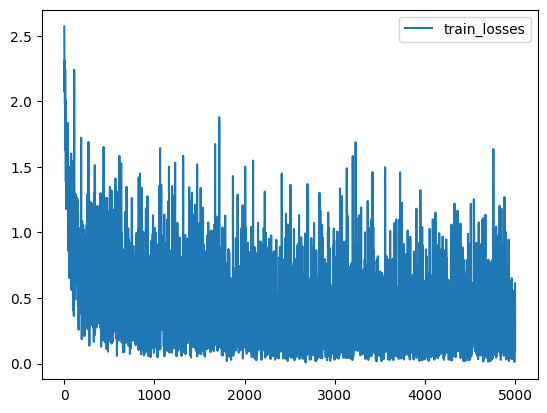

In [17]:
# Plot loss curve
plt.plot(train_loss, label="train_losses")
plt.legend()

In [18]:
evaluate(model, device, mini_vals)

Got 9221 / 10000 correct (92.21)


In [19]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [20]:
# Save Model
PATH = './cifar_net.pt'
torch.save(model, PATH)

In [21]:
# Load Model
model = torch.load(PATH).to(device)

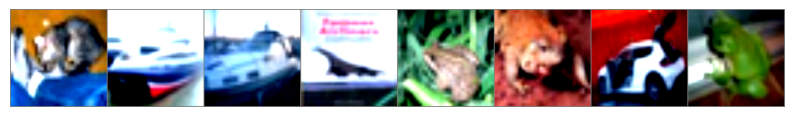

真實類別:  cat   ship  ship  plane frog  frog  car   frog 
預測類別:  cat   ship  ship  plane frog  frog  car   frog 


In [22]:
# Test on one batch of data
batch_size=8
test_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10,6))
imshow(torchvision.utils.make_grid(images))

print('真實類別: ', ' '.join(f'{classes[labels[j]]:5s}' 
                         for j in range(batch_size)))

outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('預測類別: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))